# Pre-processing pipeline

Notebook used to compute the pre-processing pipeline on the raw data coming from one deployment.

In [15]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../")
import importlib
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_function as theodo_f
import scripts.prediction_utils as prediction_u
import time
from tqdm import tqdm
import torch
from stheno.torch import B
import matplotlib.pyplot as plt

# Selection of datasets and pre-processing pipeline parameters

In [23]:
# Selection of files and parameters

# Path of the rosbags
file = [
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220224/20220224_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220307/20220307_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220314/20220314_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220316/20220316_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220525/20220525_1_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220525/20220525_2_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220622/20220622_1_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220622/20220622_2_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220630/20220630_1_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220630/20220630_2_inter_prism.bag",
        "/home/maxime/data/ICRA_2023/ICRA_2023/20220711/20220711_2_inter_prism.bag",
       ]

# Path of output
output = [
        "../data/20220224/",
        "../data/20220307/",
        "../data/20220314/",
        "../data/20220316/",
        "../data/20220525-1/",
        "../data/20220525-2/",
        "../data/20220622-1/",
        "../data/20220622-2/",
        "../data/20220630-1/",
        "../data/20220630-2/",
        "../data/20220711-2/",
]

# Parameters to select:
# 1. Apply filtering or not on the total stations raw data (Module 1) (0 or 1)
# 2-3-4. Parameters tau_r(distance threshold m/s), tau_a(azimuth threshold deg/s), tau_e(elevation threshold deg/s) (Module 1)
# 5. Parameter tau_s(split mesurements s) (Module 2)
# 6. Parameter tau_l(interval of data keep between two trajectories s) (Module 3)
# 7. Parameter to cut edge of sub-intervals (former parameter with low impact s)
# parameters = [
#     [1,2,2,2,4,4,0],
# ]
parameters = [
    [1,2,1,1,3,2,0],
]

# Pre-processing pipeline

In [24]:
theodo_u = importlib.reload(theodo_u)
theodo_f = importlib.reload(theodo_f)
prediction_u = importlib.reload(prediction_u)
from pathlib import Path

for param in parameters:
    print(param)

    if(param[0]==0):
        filtering = False
    if(param[0]==1):
        filtering = True
    thresold_d = param[1]                # tau_r [m/s]
    thresold_a = param[2]                # tau_a [deg/s]
    thresold_e = param[3]                # tau_e [deg/s]
    limit_time_interval = param[4]       # tau_s [s]

    B.epsilon = 1e-8
    Mode = "L"       # Interpolation choice: 1. L -> Linear interpolation, 2. SGP -> Gaussian Process with Stheno library
    limit_search = limit_time_interval
    size_interval = param[5]         # tau_l [s]
    delta_t = param[6]               # Value to remove points near edge of time intervals [s]
    save = True

    # GP parameters
    verbose=False
    Number_restart = 100        # Number of restart for the GP
    noise_GP = 0                # Noise of GP
    variance_GP = 1             # Variance of GP
    lengthscale_GP = 1          # Lengthscale of GP

    save_index_1 = []
    save_index_2 = []
    save_index_3 = []

    for fname, opath in zip(file,output): 
        if(not filtering):
            path = opath + "raw_prediction/"
        else:
            path = opath + "filtered_prediction/"

        if(filtering):
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data_pre_filtered(fname, msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")
            index_1_f = theodo_u.thresold_raw_data(t1, d1, a1, e1, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_2_f = theodo_u.thresold_raw_data(t2, d2, a2, e2, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            index_3_f = theodo_u.thresold_raw_data(t3, d3, a3, e3, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
            t1 = t1[index_1_f]
            t2 = t2[index_2_f]
            t3 = t3[index_3_f]
            tp1 = tp1[index_1_f].T
            tp2 = tp2[index_2_f].T
            tp3 = tp3[index_3_f].T
            print(len(t1),len(t2),len(t3))
        else:
            t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data(fname, msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")
            print(len(t1),len(t2),len(t3))

        time_origin = np.min([t1[0],t2[0],t3[0]])

        start_time = time.time()

        t1 = t1 - np.ones_like(t1)*time_origin
        t2 = t2 - np.ones_like(t2)*time_origin
        t3 = t3 - np.ones_like(t3)*time_origin

        list_interval, list_time = theodo_f.split_time_interval_all_data(t1, t2, t3, limit_time_interval)
        list_trajectories_split = theodo_f.merge_interval(list_interval, list_time, t1, t2, t3, limit_search)

        Prediction_1 = []
        Prediction_2 = []
        Prediction_3 = []
        T_prediction = []

        for i in tqdm(list_trajectories_split):

            index_1 = np.array([i[0,0],i[1,0]])
            index_2 = np.array([i[0,1],i[1,1]])
            index_3 = np.array([i[0,2],i[1,2]])

            save_index_1.append(index_1)
            save_index_2.append(index_2)
            save_index_3.append(index_3)

            if(filtering==True):
                index_1 = prediction_u.delta_t_function(index_1,t1,delta_t)
                index_2 = prediction_u.delta_t_function(index_2,t2,delta_t)
                index_3 = prediction_u.delta_t_function(index_3,t3,delta_t)

            begin = np.max([t1[index_1[0]], t2[index_2[0]], t3[index_3[0]]])
            end = np.min([t1[index_1[1]], t2[index_2[1]], t3[index_3[1]]])

            if(abs(end-begin)>size_interval and begin<end):

                rate = 5  #Hz
                T_prediction_init = torch.from_numpy(np.arange(begin, end, 1/rate))

                # Test done for Multiple Gaussian Process Output
                if(Mode == "MGPO" or Mode == "All"):
                    T_MGPO, S_MGPO = prediction_u.data_training_MGPO(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    m = prediction_u.training_MGPO(Number_restart, verbose, T_MGPO, S_MGPO)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_MGPO, P2_MGPO, P3_MGPO = prediction_u.unit_prediction_MGPO(i, m)
                        Prediction_1.append(P1_MGPO)
                        Prediction_2.append(P2_MGPO)
                        Prediction_3.append(P3_MGPO)

                # Gaussian process with GPy library
                if(Mode == "GP" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_GP(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Training")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = prediction_u.training_GP(Number_restart, verbose, T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
                    print("Prediction")
                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = prediction_u.unit_prediction_GP(i, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                # Linear interpolation
                if(Mode == "L" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_L(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    print("Prediction")
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = prediction_u.linear_interpolation(T1, X1, Y1, Z1, T2, X2, Y2, Z2,T3, X3, Y3, Z3)

                    for i in T_prediction_init.numpy():
                        T_prediction.append(i+time_origin)
                        P1_GP, P2_GP, P3_GP = prediction_u.linear_prediction(i, time_origin, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                        Prediction_1.append(P1_GP)
                        Prediction_2.append(P2_GP)
                        Prediction_3.append(P3_GP)

                # Gaussian process with Stheno library
                if(Mode=="SGP"):
                    prediction_value = T_prediction_init.numpy()
                    # Prepare data for training
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = prediction_u.data_training_GP_stheno(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
                    # Training for each axis
                    m_X1, v_X1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=X1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y1, v_Y1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Y1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z1, v_Z1 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Z1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X2, v_X2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=X2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y2, v_Y2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Y2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z2, v_Z2 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Z2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_X3, v_X3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=X3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Y3, v_Y3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Y3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)
                    m_Z3, v_Z3 = prediction_u.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Z3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=Number_restart)

                    # Save prediction at time i
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X1, m_Y1, m_Z1, v_X1, v_Y1, v_Z1):
                        Prediction_1.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                        T_prediction.append(i+time_origin)
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X2, m_Y2, m_Z2, v_X2, v_Y2, v_Z2):
                        Prediction_2.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))
                    for i,mx,my,mz,vx,vy,vz in zip(T_prediction_init.numpy(), m_X3, m_Y3, m_Z3, v_X3, v_Y3, v_Z3):
                        Prediction_3.append(np.array([i+time_origin, mx ,my, mz, vx, vy, vz]))

        stop_time = time.time()
        print(stop_time - start_time)

        print("Interpolation finished !")

        if save:
            if(Mode == "MGPO" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-MGPO-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "GP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-GP-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "SGP" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-SGP-"+str(Number_restart)

                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                theodo_u.Convert_data_prediction_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")
            if(Mode == "L" or Mode == "All"):
                if(filtering):
                    trajectoire = "f-"+str(thresold_d)+"-"+str(thresold_a)+"-"+str(thresold_e)+"-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"
                else:
                    trajectoire = "nf-"+str(limit_time_interval)+"-"+str(size_interval)+"-"+str(delta_t)+"-L"

                if save:
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_1, path+trajectoire+ "_1.csv")
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_2, path+trajectoire+ "_2.csv")
                    theodo_u.Convert_raw_data_point_to_csv(T_prediction, Prediction_3, path+trajectoire+ "_3.csv")

        print("Saved !")

[1, 2, 1, 1, 3, 2, 0]
Number of data for theodolites: [4945 4681 4737]
Bad measures: 558
3836 3619 3690


 15%|█▍        | 7/47 [00:00<00:00, 56.48it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 43%|████▎     | 20/47 [00:00<00:00, 57.51it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 79%|███████▊  | 37/47 [00:00<00:00, 70.07it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 47/47 [00:00<00:00, 52.84it/s]

Prediction
Prediction
Prediction
Prediction
1.0702829360961914
Interpolation finished !


Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [7292 6861 7123]
Bad measures: 556
5915 5516 5773


  7%|▋         | 5/69 [00:00<00:02, 30.18it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 45%|████▍     | 31/69 [00:00<00:00, 74.29it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 70%|██████▉   | 48/69 [00:00<00:00, 64.55it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 69/69 [00:01<00:00, 60.03it/s]

Prediction
Prediction
Prediction
1.5391180515289307
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [7505 7107 7482]
Bad measures: 704
4610 4387 4633


 28%|██▊       | 11/39 [00:00<00:00, 75.77it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 54%|█████▍    | 21/39 [00:00<00:00, 84.14it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 77%|███████▋  | 30/39 [00:00<00:00, 55.27it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 39/39 [00:00<00:00, 40.55it/s]

Prediction
Prediction
Prediction
1.161620855331421
Interpolation finished !


Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [5680 5508 5382]
Bad measures: 459
3714 3563 3513


 48%|████▊     | 20/42 [00:00<00:00, 43.73it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 71%|███████▏  | 30/42 [00:00<00:00, 57.30it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 42/42 [00:00<00:00, 50.92it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.9856960773468018
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


Number of data for theodolites: [4214 3791 3347]
Bad measures: 924
3821 3423 2961


  0%|          | 0/21 [00:00<?, ?it/s]

Prediction
Prediction
Prediction
Prediction


 19%|█▉        | 4/21 [00:00<00:00, 34.50it/s]

Prediction
Prediction
Prediction
Prediction


 38%|███▊      | 8/21 [00:00<00:00, 26.62it/s]

Prediction
Prediction


 67%|██████▋   | 14/21 [00:00<00:00, 23.26it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 21/21 [00:00<00:00, 24.53it/s]

Prediction
Prediction
0.927844762802124
Interpolation finished !
Conversion done !


Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [8368 7986 7909]
Bad measures: 692
7462 7089 7004


 14%|█▎        | 6/44 [00:00<00:01, 27.94it/s]

Prediction
Prediction
Prediction
Prediction
Prediction


 30%|██▉       | 13/44 [00:00<00:00, 31.04it/s]

Prediction
Prediction
Prediction
Prediction
Prediction


 39%|███▊      | 17/44 [00:00<00:00, 32.43it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 55%|█████▍    | 24/44 [00:00<00:00, 22.89it/s]

Prediction
Prediction
Prediction
Prediction
Prediction


 68%|██████▊   | 30/44 [00:01<00:00, 21.70it/s]

Prediction
Prediction
Prediction
Prediction
Prediction


 86%|████████▋ | 38/44 [00:01<00:00, 28.50it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 95%|█████████▌| 42/44 [00:01<00:00, 24.85it/s]

Prediction
Prediction
Prediction
Prediction


100%|██████████| 44/44 [00:01<00:00, 25.95it/s]


Prediction
Prediction
2.0102055072784424
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [2321 2283 2246]
Bad measures: 785
2049 2033 2020


 50%|█████     | 9/18 [00:00<00:00, 38.18it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 18/18 [00:00<00:00, 41.73it/s]


Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.4716808795928955
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [1936 2134 2304]
Bad measures: 351
1782 1973 2126


  0%|          | 0/11 [00:00<?, ?it/s]

Prediction
Prediction
Prediction


 36%|███▋      | 4/11 [00:00<00:00, 21.69it/s]

Prediction


 64%|██████▎   | 7/11 [00:00<00:00, 24.69it/s]

Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 11/11 [00:00<00:00, 23.63it/s]

Prediction
0.4920666217803955
Interpolation finished !
Conversion done !


Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [2809 2565 2199]
Bad measures: 1266
1802 1619 1286


 21%|██▏       | 6/28 [00:00<00:00, 54.53it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 28/28 [00:00<00:00, 122.57it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.27598047256469727
Interpolation finished !


Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [3144 2757 3053]
Bad measures: 517
2078 1827 2116


 32%|███▏      | 10/31 [00:00<00:00, 97.26it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 68%|██████▊   | 21/31 [00:00<00:00, 95.50it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 31/31 [00:00<00:00, 109.68it/s]


Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.3415954113006592
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !
Number of data for theodolites: [3529 3342 3320]
Bad measures: 777
2861 2771 2704


  0%|          | 0/36 [00:00<?, ?it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


 33%|███▎      | 12/36 [00:00<00:00, 104.20it/s]

Prediction
Prediction
Prediction


 64%|██████▍   | 23/36 [00:00<00:00, 50.98it/s] 

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction


100%|██████████| 36/36 [00:00<00:00, 66.64it/s]

Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
Prediction
0.6384024620056152
Interpolation finished !
Conversion done !
Conversion done !
Conversion done !
Saved !


# Display results

In [25]:
theodo_u = importlib.reload(theodo_u)

k = "../data/20220525-1/"
path_type = 'filtered_prediction/'
#path_file_type = 'nf-1-6-1-L_'
path_file_type = 'f-2-1-1-3-2-0-L_'

trimble_1 = theodo_u.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = theodo_u.read_rosbag_theodolite_without_tf_raw_data(file[0], msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")

Number of data for theodolites: [4945 4681 4737]
Bad measures: 558


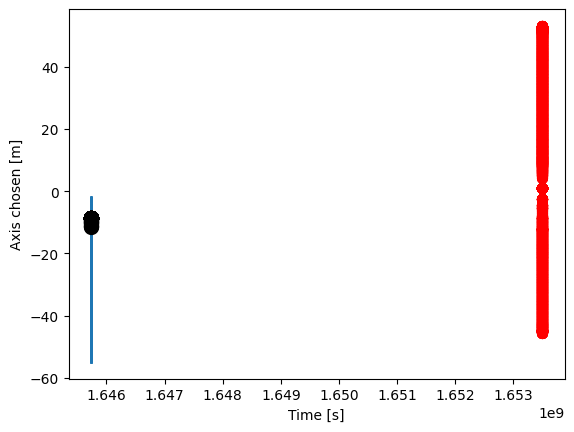

In [26]:
%matplotlib inline

save_index_1_arr = np.array(save_index_1)
i = save_index_1_arr[0]

plt.figure()

plt.scatter(t1,tp1[0,:],s =1)                                               # Raw data from rosbag
plt.scatter(t1[i[0]:i[1]],tp1[0,i[0]:i[1]], linewidth=5, color= 'black')      # Data given as input for the interpolation
plt.scatter(trimble_1[:,0],trimble_1[:,1], linewidth=2, color= 'red')       # Interpolated points
plt.xlabel("Time [s]")
plt.ylabel("Axis chosen [m]")


plt.show()